In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd


# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



from typing import Iterable
from pathlib import Path



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [3]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']
initial_state = 'A'
state = 'New York'
if 'State' in feature_names_base:
    feature_names_base.remove('State')




train_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                weather_data_path=weather_data_file,
                                                                                power_load_data_path=power_load_file,
                                                                                feature_names=feature_names_base,
                                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                state_one_hot=False,
                                                                                initial_MC_state_filter=initial_state,
                                                                                technology_filter=technologies,
                                                                                test_periods=test_periods,
                                                                                state_filter=state
                                                                                )


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
Standardized features (31): ['Tmin', '1d_load_sum', 'Pressure_3hr_change', 'HDD3d', 'Wind_chill', 'Tmax', 'Tmean', 'Extreme_cold', 'Load', 'Relative_humidity', '24h_max_load', 'Precip_1d', 'Extreme_heat', 'FDD3d', 'Wet_bulb_temperature', '24h_min_load', 'Snow_depth', 'CDD3d', 'Precip_3d', 'Temperature', '2d_load_sum', 'Heat_index', 'FDD', 'Sea_level_pressure', 'HDD', 'Hourly_load_change', 'Station_level_pressure', 'Wind_speed', 'Precipitation', '

In [4]:
def clean_state_name(state_col: str) -> str:
    s = state_col.split('_')[1]
    clean_s = ''
    for w in s.split( ' '):
        clean_s += w.capitalize() + ' '
    state = clean_s.strip()
    return state

# Load models

In [56]:
importlib.reload(im)
models_to_test = {}


In [ ]:
importlib.reload(im)

# Cross entropy base model
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_State_A_InitState_California_ce.pth")
models_to_test['MLP_CE'] = mlp_model

# Focal loss model (constant scheduling)
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_State_A_InitState_California_constant.pth")
models_to_test['MLP_FL_Constant'] = mlp_model

# Focal loss model (linear scheduling)
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_State_A_InitState_California_linear.pth")
models_to_test['MLP_FL_Linear'] = mlp_model

# Focal loss model (exponential scheduling)
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_State_A_InitState_California_exponential.pth")
models_to_test['MLP_FL_Exponential'] = mlp_model    

# Focal loss model (cosine scheduling)
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_State_A_InitState_California_cosine.pth")
models_to_test['MLP_FL_Cosine'] = mlp_model


Sequential(
  (linear_0): Linear(in_features=43, out_features=128, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=64, out_features=64, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=64, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=64, out_features=64, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=64, out_features=64, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=64, out_features=64, bias=True)
  (activation_7): ReLU()
  (linear_8): Linear(in_features=64, out_features=64, bias=True)
  (activation_8): ReLU()
  (linear_9): Linear(in_features=64, out_features=64, bias=True)
  (activation_9): ReLU()
  (linear_10): Linear(in_features=64, out_features=64, bias=True)
  (activation_10):

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [57]:
class composition_models:
    def __init__(self):
        self.model_to_D = None
        self.model_to_U = None

        self.feature_cols = None
    
    def predict(self, X):
        D_probs = self.model_to_D.predict(X)[:, 1]
        U_probs = self.model_to_U.predict(X)[:, 1]
        A_probs = 1 - D_probs - U_probs
        # Combine probabilities (example: average)
        combined_probs = np.vstack((A_probs, D_probs, U_probs)).T
        return combined_probs
    
    def load_D_model(self, path: str, model_type: str = 'xgboost'):
        if model_type == 'xgboost':
            model_loader = xgb.XGBClassifier()
            model = model_loader.load_model(path)
            self.model_to_D = model
        elif model_type == 'mlp':
            mlp_loader = im.MLP(verbose=False)
            model = mlp_loader.load_model(path)
            self.model_to_D = model
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        if self.feature_cols is None:
            self.feature_cols = model.feature_cols
        else:
            if self.feature_cols != model.feature_cols:
                raise ValueError("Feature columns of the loaded model do not match the existing feature columns.")
    
    def load_U_model(self, path: str, model_type: str = 'xgboost'):
        if model_type == 'xgboost':
            model_loader = xgb.XGBClassifier()
            model = model_loader.load_model(path)
            self.model_to_U = model
        elif model_type == 'mlp':
            mlp_loader = im.MLP(verbose=False)
            model = mlp_loader.load_model(path)
            self.model_to_U = model
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        if self.feature_cols is None:
            self.feature_cols = model.feature_cols
        else:
            if self.feature_cols != model.feature_cols:
                raise ValueError("Feature columns of the loaded model do not match the existing feature columns.")

In [158]:
combined_model = composition_models()
combined_model.load_D_model("../Results/Models/model_MLP_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
combined_model.load_U_model("../Results/Models/model_MLP_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')

models_to_test['MLP_Composition_w2'] = combined_model

Sequential(
  (linear_0): Linear(in_features=43, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=256, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=256, out_features=128, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=128, out_features=64, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=64, out_features=64, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=64, out_features=64, bias=True)
  (activation_7): ReLU()
  (linear_8): Linear(in_features=64, out_features=64, bias=True)
  (activation_8): ReLU()
  (linear_9): Linear(in_features=64, out_features=64, bias=True)
  (activation_9): ReLU()
  (linear_out): Linear(in_features=64, out_features=2, bias=True)
)
Input dim:

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [221]:
mlp_loader = im.MLP(verbose=False)
mlp_model = mlp_loader.load_model("../Results/Models/model_MLP_Tech_thermal_fr_A_to_all_State_New York.pth")
models_to_test['MLP_all'] = mlp_model

Sequential(
  (linear_0): Linear(in_features=43, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=256, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=256, out_features=128, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=128, out_features=64, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=64, out_features=64, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=64, out_features=64, bias=True)
  (activation_7): ReLU()
  (linear_8): Linear(in_features=64, out_features=64, bias=True)
  (activation_8): ReLU()
  (linear_9): Linear(in_features=64, out_features=64, bias=True)
  (activation_9): ReLU()
  (linear_out): Linear(in_features=64, out_features=3, bias=True)
)
Input dim:

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Comparison

In [59]:
def CE_min(df, features):
    """Returns the probabilities that minimize the cross entropy on the test set (for comparison with model predictions)"""
    df_counts = df[features+['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts =  df_counts.groupby(features).sum('count')
    res = df.join(counts, on=features,  how='left')
    res["probability_CE_min"] = res['Data_weight'] / res['count']

    p0 = res.loc[res['Final_gen_state']==0]
    p1 = res.loc[res['Final_gen_state']==1]
    p2 = res.loc[res['Final_gen_state']==2]

    p0 = p0.groupby(['Datetime_UTC']+features).sum()
    p1 = p1.groupby(['Datetime_UTC']+features).sum()
    p2 = p2.groupby(['Datetime_UTC']+features).sum()

    p0 = p0['probability_CE_min']
    p1 = p1['probability_CE_min']
    p2 = p2['probability_CE_min']

    res = res.join(p0, on=['Datetime_UTC']+features, how='left', rsuffix='_0')
    res = res.join(p1, on=['Datetime_UTC']+features, how='left', rsuffix='_1')
    res = res.join(p2, on=['Datetime_UTC']+features, how='left', rsuffix='_2')

    res.fillna(0, inplace=True)

    probs = res[['probability_CE_min_0', 'probability_CE_min_1', 'probability_CE_min_2']].to_numpy()

    return probs

In [60]:
def freq_model(df_train, features, target_cols):
    """Returns the frequency-based model probability on the test set (for comparison with model predictions).
    We compute historical frequency of transition for each state and technology, and use it as a model. It is agnostic to any other features."""
    states = [f for f in df_train.columns if f.startswith("State_")]
    techs = [f for f in df_train.columns if f.startswith("Technology_")]

    if not states and not techs:
        freq = df_train.groupby(target_cols).sum('Data_weight')
        total = freq['Data_weight'].sum()

        prob_dict = {}
        gen_states = freq.index.unique()
        prob_dict = [ (freq.loc[init_state]['Data_weight'] / total) for init_state in gen_states]
        def p(input_df):
            if isinstance(input_df, pd.DataFrame):
                out = np.array([prob_dict for _ in range(len(input_df))])
                return out
            else:
                return np.array(prob_dict)
        return p

    df_counts = df_train[states + techs + target_cols + ['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts = df_counts.groupby(states + techs + target_cols).sum('count').reset_index()
    counts_total = counts.groupby(states + techs).sum('count')
    counts = counts.join(counts_total, how='left', on=states + techs, rsuffix='_total')
    counts['prob'] = counts['count'] / counts['count_total']

    for s in states:
        counts.rename(columns={s: clean_state_name(s)}, inplace=True)
    states_clean = [clean_state_name(s) for s in states]


    prob_dict = {}
    gen_states = counts[target_cols[0]].unique()
    for s in states_clean:
        prob_dict[s] = {}
        if techs:
            for t in techs:
                mask = (counts[s]==1)&(counts[t]==1)
                sub_counts = counts.loc[mask]
                if not sub_counts.empty:
                    prob_dict[s][t] = []
                    for init_state in gen_states:
                        mask2 = sub_counts[target_cols[0]] == init_state
                        if not sub_counts.loc[mask2].empty:
                            prob = sub_counts.loc[mask2]['prob'].values[0]
                        else:
                            prob = 0.0
                        prob_dict[s][t].append(prob)
                else:
                    prob_dict[s][t] = [0.0 for _ in gen_states]
        else:
            mask = (counts[s]==1)
            sub_counts = counts.loc[mask]
            if not sub_counts.empty:
                prob_dict[s] = []
                for init_state in gen_states:
                    mask2 = sub_counts[target_cols[0]] == init_state
                    if not sub_counts.loc[mask2].empty:
                        prob = sub_counts.loc[mask2]['prob'].values[0]
                    else:
                        prob = 0.0
                    prob_dict[s].append(prob)
            else:
                prob_dict[s] = [0.0 for _ in gen_states]


    def p(input_df):
        # vectorized prediction for DataFrame input
        if isinstance(input_df, pd.DataFrame):
            # get winning state and technology column names per row
            state_cols = input_df[states]
            tech_cols = input_df[techs]

            state_idx = state_cols.idxmax(axis=1)  # e.g. "State_NORTH DAKOTA"
            if not tech_cols.empty:
                tech_idx = tech_cols.idxmax(axis=1)    # e.g. "Technology_CC GT units"

            # clean state names to match keys in prob_dict (capitalise words)
            states_clean = state_idx.str.replace("State_", "", regex=False).str.title()

            # build a mapping (state_clean, tech_col) -> probability array
            pair_to_probs = {}
            if not tech_cols.empty:
                for s, techs_dict in prob_dict.items():
                    for t, arr in techs_dict.items():
                        pair_to_probs[(s, t)] = np.asarray(arr)
            else:
                for s, arr in prob_dict.items():
                    pair_to_probs[(s)] = np.asarray(arr)
            # for s, techs_dict in prob_dict.items():
            #     for t, arr in techs_dict.items():
            #         pair_to_probs[(s, t)] = np.asarray(arr)

            # determine number of classes (use any entry) and default vector
            if pair_to_probs:
                sample_vec = next(iter(pair_to_probs.values()))
                n_classes = sample_vec.shape[0]
                default_vec = np.zeros(n_classes, dtype=sample_vec.dtype)
            else:
                return np.empty((len(input_df), 0))

            # build MultiIndex DataFrame for fast reindexing
            tuples = list(pair_to_probs.keys())
            probs_matrix = np.vstack(list(pair_to_probs.values()))
            if techs:
                probs_df = pd.DataFrame(probs_matrix, index=pd.MultiIndex.from_tuples(tuples, names=("state","tech")))
            else:
                probs_df = pd.DataFrame(probs_matrix, index=pd.Index(tuples, name="state"))

            # create index of requested pairs and reindex (fills missing with NaN -> replace with zeros)
            if techs:
                requested_pairs = list(zip(states_clean.values, tech_idx.values))
            else:
                requested_pairs = list(states_clean.values)
            out = probs_df.reindex(requested_pairs).fillna(0).values

            return out

        # scalar (single row / Series) input
        else:
            state = clean_state_name(input_df[states].idxmax())
            if techs:
                tech = input_df[techs].idxmax()
                return np.array(prob_dict.get(state, {}).get(tech, []))
            else:
                return np.array(prob_dict.get(state, {}))


    return p

In [61]:
def cross_entropy(probs: np.ndarray, true_labels: np.ndarray, weights: np.ndarray) -> float:
    """
    Compute the cross-entropy loss given predicted probabilities and true labels.

    Parameters:
    probs (np.ndarray): Predicted probabilities for each class (shape: [n_samples, n_classes]).
    true_labels (np.ndarray): True class labels (shape: [n_samples]).
    weights (np.ndarray): Sample weights (shape: [n_samples]).

    Returns:
    float: Cross-entropy loss.
    """
    n_samples = true_labels.shape[0]
    # Clip probabilities to avoid log(0)
    clipped_probs = np.clip(probs, 1e-15, 1 - 1e-15)
    # Get the probabilities corresponding to the true labels
    true_class_probs = clipped_probs[np.arange(n_samples), true_labels]
    # Compute cross-entropy
    ce_loss = -np.sum(np.log(true_class_probs) * weights) / np.sum(weights)
    return ce_loss


In [62]:
y_true = test_df['Final_gen_state'].to_numpy()
sample_weights = test_df['Data_weight'].to_numpy()

In [222]:
model_scores = {}

In [223]:
eval_data = test_df

In [224]:
# states = train_df['Final_gen_state'].unique()

for model_name, model in models_to_test.items():
    model_scores[model_name] = {}
    targets = eval_data['Final_gen_state'].to_numpy()
    weights = eval_data['Data_weight'].to_numpy()
    print(f"Evaluating model: {model_name}")
    probs = model.predict(eval_data[model.feature_cols].copy())
    ce = cross_entropy(probs, targets, weights)
    print(f"  Cross-entropy loss: {ce:.6f}")
    model_scores[model_name]['Overall'] = ce
    for sname, s in integer_encoding['Final_gen_state'].items():
        state_df = eval_data[eval_data['Final_gen_state'] == s].copy()
        targets = state_df['Final_gen_state'].to_numpy()
        weights = state_df['Data_weight'].to_numpy()
        print(f"Evaluating model: {model_name} for state {sname}")
        probs = model.predict(state_df[model.feature_cols].copy())
        ce_loss = cross_entropy(probs, targets, weights)
        print(f"  Cross-entropy loss for state {sname}: {ce_loss:.6f}")
        model_scores[model_name][s] = ce_loss

Evaluating model: MLP_Composition
  Cross-entropy loss: 0.006268
Evaluating model: MLP_Composition for state A
  Cross-entropy loss for state A: 0.000686
Evaluating model: MLP_Composition for state D
  Cross-entropy loss for state D: 10.377170
Evaluating model: MLP_Composition for state U
  Cross-entropy loss for state U: 7.224353
Evaluating model: MLP_Composition_no_weighting


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/valida

  Cross-entropy loss: 0.019220
Evaluating model: MLP_Composition_no_weighting for state A
  Cross-entropy loss for state A: 0.000063
Evaluating model: MLP_Composition_no_weighting for state D
  Cross-entropy loss for state D: 9.833691
Evaluating model: MLP_Composition_no_weighting for state U
  Cross-entropy loss for state U: 27.631020
Evaluating model: MLP_Composition_w2
  Cross-entropy loss: 0.007484
Evaluating model: MLP_Composition_w2 for state A
  Cross-entropy loss for state A: 0.000592
Evaluating model: MLP_Composition_w2 for state D
  Cross-entropy loss for state D: 27.631020
Evaluating model: MLP_Composition_w2 for state U
  Cross-entropy loss for state U: 7.286650
Evaluating model: MLP_all
  Cross-entropy loss: 0.006544
Evaluating model: MLP_all for state A
  Cross-entropy loss for state A: 0.000987
Evaluating model: MLP_all for state D
  Cross-entropy loss for state D: 9.523888
Evaluating model: MLP_all for state U
  Cross-entropy loss for state U: 7.281611


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/valida

In [225]:
model_scores['Frequency_Model'] = {}
targets = eval_data['Final_gen_state'].to_numpy()
weights = eval_data['Data_weight'].to_numpy()
print(f"Evaluating model: Frequency_Model")
freq_p = freq_model(eval_data, feature_names, ['Final_gen_state'])
probs_freq = freq_p(eval_data[feature_names])
ce_freq = cross_entropy(probs_freq, targets, weights)
print(f"  Cross-entropy loss: {ce_freq:.6f}")
model_scores['Frequency_Model']['Overall'] = ce_freq
for sname, s in integer_encoding['Final_gen_state'].items():
    state_df = eval_data[eval_data['Final_gen_state'] == s].copy()
    targets = state_df['Final_gen_state'].to_numpy()
    weights = state_df['Data_weight'].to_numpy()
    print(f"Evaluating model: Frequency_Model for state {s}")
    freq_p = freq_model(train_df, feature_names, ['Final_gen_state'])
    probs_freq = freq_p(state_df[feature_names])
    ce_freq = cross_entropy(probs_freq, targets, weights)
    print(f"  Cross-entropy loss for state {s}: {ce_freq:.6f}")
    model_scores['Frequency_Model'][s] = ce_freq

Evaluating model: Frequency_Model
  Cross-entropy loss: 0.006319
Evaluating model: Frequency_Model for state 0
  Cross-entropy loss for state 0: 0.000779
Evaluating model: Frequency_Model for state 1
  Cross-entropy loss for state 1: 9.466698
Evaluating model: Frequency_Model for state 2
  Cross-entropy loss for state 2: 7.262232


In [226]:
model_scores['min_CE'] = {}
targets = eval_data['Final_gen_state'].to_numpy()
weights = eval_data['Data_weight'].to_numpy()
print(f"Computing minimal cross-entropy")
probs_freq = CE_min(eval_data, features=feature_names)
ce = cross_entropy(probs_freq, targets, weights)
print(f"  Cross-entropy loss: {ce:.6f}")
model_scores['min_CE']['Overall'] = ce
# for sname, s in integer_encoding['Final_gen_state'].items():
#     state_df = eval_data[eval_data['Final_gen_state'] == s].copy()
#     targets = state_df['Final_gen_state'].to_numpy()
#     weights = state_df['Data_weight'].to_numpy()
#     print(f"Evaluating model: Frequency_Model for state {s}")
#     p = CE_min(eval_data, features=feature_names)
#     p = p[state_df.index]
#     ce = cross_entropy(p, targets, weights)
#     print(f"  Cross-entropy loss for state {s}: {ce:.6f}")
#     model_scores['min_CE'][s] = ce

Computing minimal cross-entropy
  Cross-entropy loss: 0.003645


In [227]:
model_scores_df = pd.DataFrame(model_scores)
model_scores_df

,MLP_Composition,MLP_Composition_no_weighting,MLP_Composition_w2,MLP_all,Frequency_Model,min_CE
Overall,0.006268,0.019220,0.007484,0.006544,0.006319,0.003645
0,0.000686,0.000063,0.000592,0.000987,0.000779,NaN
1,10.377170,9.833691,27.631020,9.523888,9.466698,NaN
2,7.224353,27.631020,7.286650,7.281611,7.262232,NaN


In [228]:
models_order = ['min_CE','Frequency_Model', 'MLP_all', 'MLP_CE', 'MLP_FL_Constant', 'MLP_FL_Linear', 'MLP_FL_Exponential', 'MLP_FL_Cosine', 'MLP_Composition', 'MLP_Composition_no_weighting', 'MLP_Composition_w2']
models_order = [m for m in models_order if m in model_scores_df.columns]
print("Model order for visualization:", models_order)
model_scores_df = model_scores_df[models_order]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models_order)}

Model order for visualization: ['min_CE', 'Frequency_Model', 'MLP_all', 'MLP_Composition', 'MLP_Composition_no_weighting', 'MLP_Composition_w2']


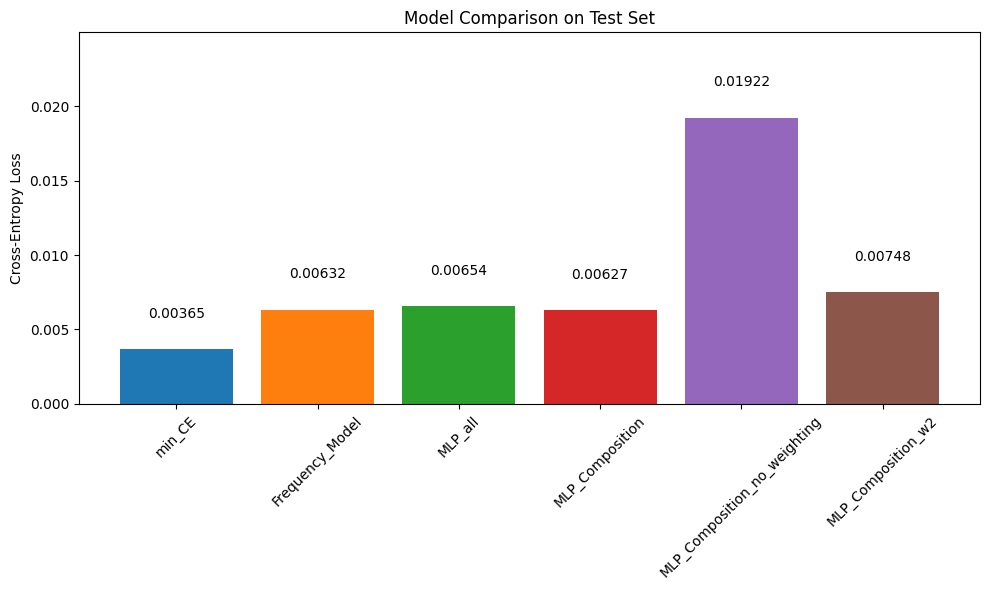

In [229]:
fig, ax = plt.subplots(figsize=(10, 6))
res = model_scores_df.loc['Overall']
ax.bar(res.index, res.values, color=[model_colors[m] for m in res.index])
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Model Comparison on Test Set')
for j, v in enumerate(res.values):
    ax.text(j, v + 0.1*max(res.values), f"{v:.5f}", ha='center', va='bottom')

ax.set_ylim(0, max(res.values)*1.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

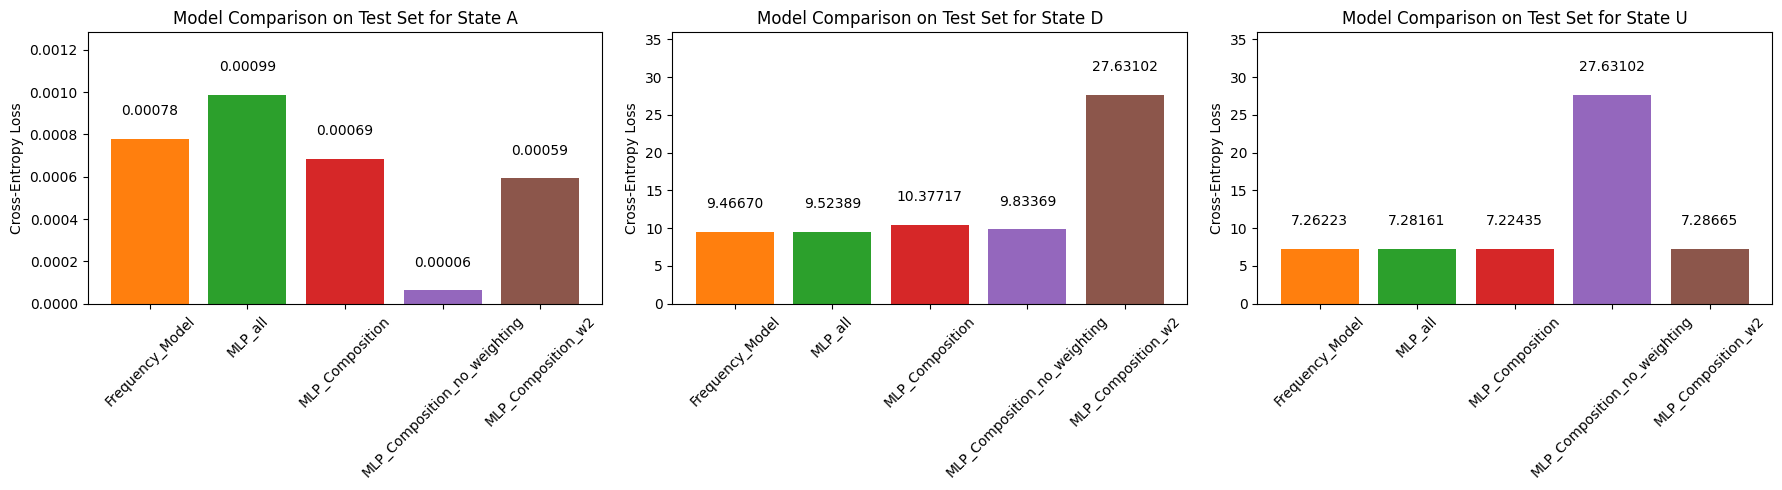

In [230]:
fig, ax = plt.subplots(1,3,figsize=(18, 5))
for sname, s in integer_encoding['Final_gen_state'].items():
    res = model_scores_df.loc[s].copy()
    res = res.dropna()
    ax[s].bar(res.index, res.values, color=[model_colors[m] for m in res.index])
    ax[s].set_ylabel('Cross-Entropy Loss')
    ax[s].set_title(f'Model Comparison on Test Set for State {sname}')
    plt.sca(ax[s])
    plt.xticks(rotation=45)
    for j, v in enumerate(res.values):
        ax[s].text(j, v + 0.1*max(res.values), f"{v:.5f}", ha='center', va='bottom')
    ax[s].set_ylim(0, max(res.values)*1.3)
plt.tight_layout()
plt.show()

In [231]:
all_data = pd.concat([test_df, train_df])

In [242]:
def plot_prob_inference(feature: str, data_df: pd.DataFrame):
    colors_states = {'A': 'green', 'D': 'red', 'U': 'blue'}
    if feature not in feature_names:
        raise ValueError(f"Feature '{feature}' not found in feature names.")


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    # for i, final_state in enumerate(['A', 'D', 'U']):
        # ax = axs[i]
    feat_min = data_df[feature].min()
    feat_max = data_df[feature].max()
    feat_range = np.linspace(feat_min, feat_max, 100)
    gap_x = feat_range[1]-feat_range[0]

    inputs = data_df.copy()
    x_vals = data_df[feature].values
    weights = inputs['Data_weight'].values

    probs_models = {}

    for model_name, model in models_to_test.items():
        mlp_features = model.feature_cols
        prob_mlp = model.predict(inputs[mlp_features])
        prob_mlp_plot = []
        for x in feat_range:
            f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
            if sum(weights[f_idx]) == 0:
                prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
                continue
            prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
        prob_mlp = np.array(prob_mlp_plot)
        probs_models[model_name] = prob_mlp
        
        # mlp_features = models[initial_state]['mlp'].feature_cols
        # prob_mlp = models[initial_state]['mlp'].predict(inputs[mlp_features])
        # prob_xgb_plot = []
        # prob_mlp_plot = []
        # for x in feat_range:
        #     f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
        #     if sum(weights[f_idx]) == 0:
        #         prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
        #         prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
        #         continue
        #     prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
        #     prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
        # prob_xgb = np.array(prob_xgb_plot)
        # prob_mlp = np.array(prob_mlp_plot)



        # Compute empirical frequency

    empirical_feq = CE_min(data_df, mlp_features)

    avg_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = empirical_feq[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        # if n_interval > 0:
        #     avg_prob = np.sum(f, axis=0) / n_interval
        # else:
        #     avg_prob = np.array([np.nan, np.nan, np.nan])
        avg_probs.append(avg_prob)
        


    for j, end_state in enumerate(['A', 'D', 'U']):
        ax = axs[j]
        ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg to {end_state}', linestyle='-', linewidth=3, color=colors_states[end_state])
        for model_name, prob_mlp in probs_models.items():
            color_idx = list(models_to_test.keys()).index(model_name) % len(colors)

            ax.plot(feat_range, prob_mlp[:, j], label=f'{model_name} to {end_state}', linestyle='--', color=model_colors[model_name])
        # ax.plot(feat_range, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])

        ax.set_title(f'End State: {end_state}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Predicted Transition Probability')
        ax.legend()
    # vals4axis = np.concatenate([prob_xgb[:, [k for k in range(3) if k != i]].flatten(), prob_mlp[:, [k for k in range(3) if k != i]].flatten()])
    # vals4axis = vals4axis[~np.isnan(vals4axis)]
    # ax.set_ylim(0, 5 * np.mean(vals4axis))
    plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
    plt.tight_layout()


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/valida

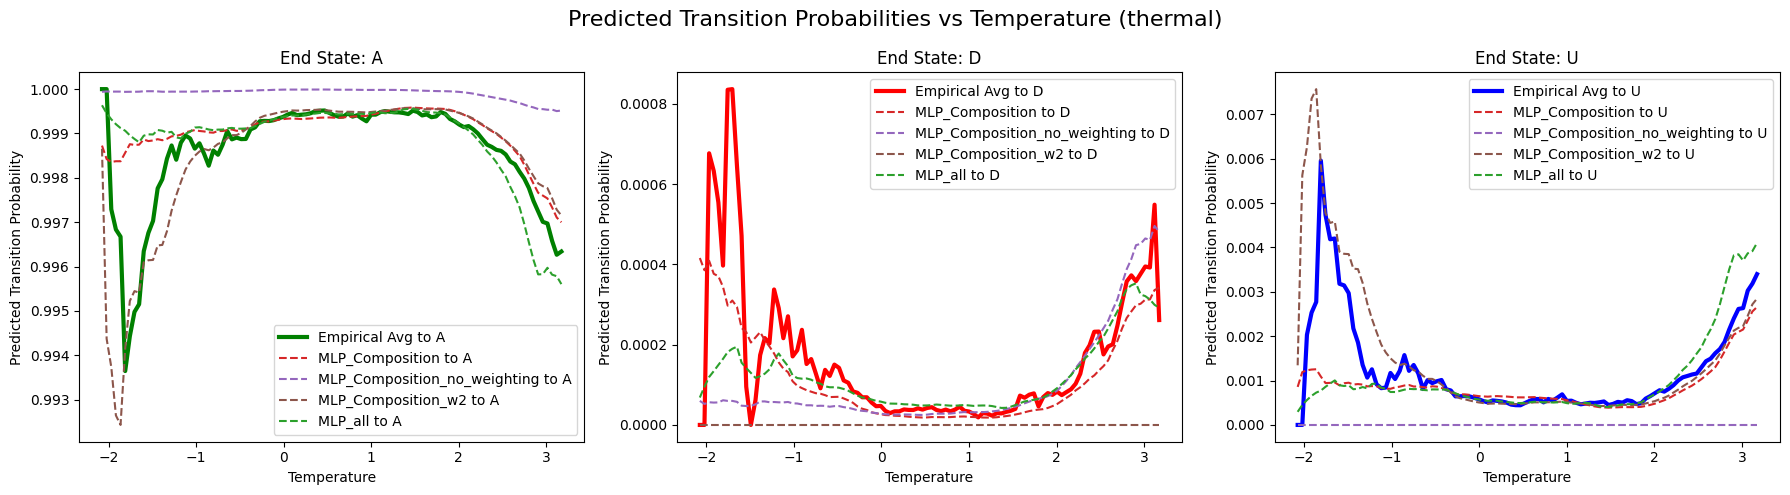

In [243]:
plot_prob_inference('Temperature', train_df)

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/valida

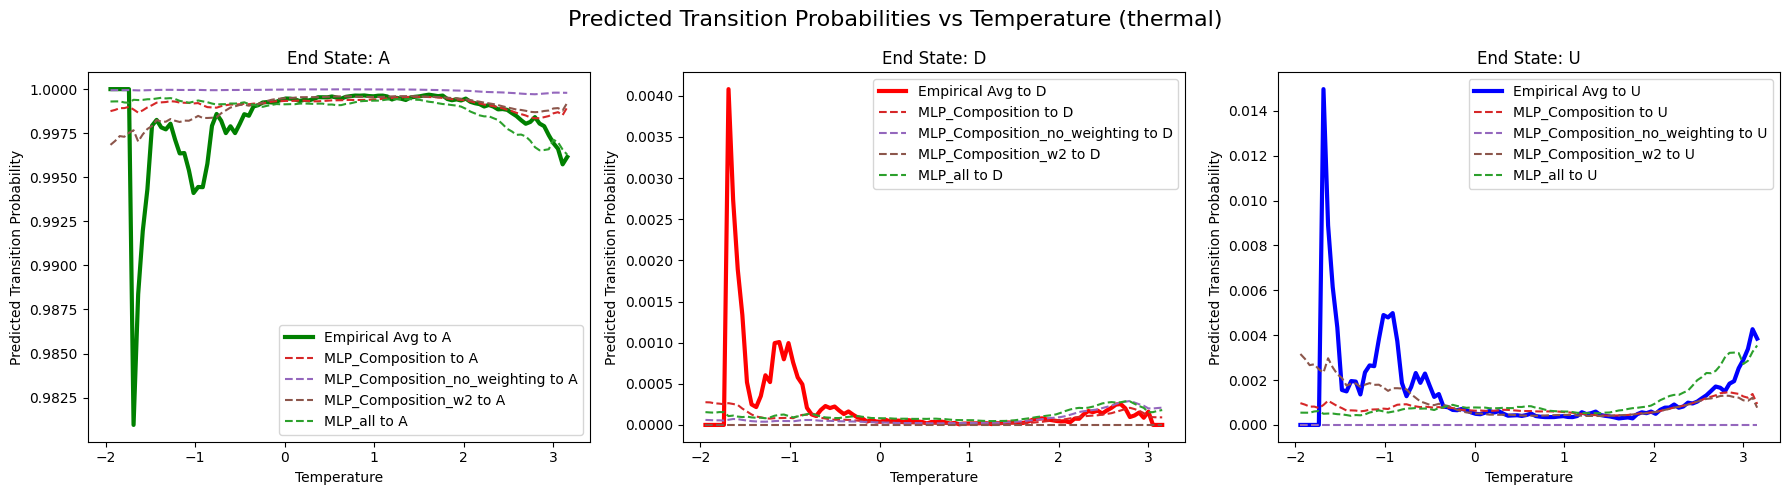

In [244]:
plot_prob_inference('Temperature', test_df)